### Import and download (option) required libraries

In [179]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import ngrams
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec
import re

In [2]:
# Download NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Load Spacy (optional)
!pip install spacy
!python -m spacy download en

import spacy
nlp = spacy.load("en_core_web_sm")

2023-11-24 07:44:11.361628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 07:44:11.361709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 07:44:11.361767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 07:44:13.189880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation succe

In [9]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading dataset

In [59]:
train_df = pd.read_csv('/content/drive/MyDrive/EDA_NLP/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/EDA_NLP/test.csv')
sample_df = pd.read_csv('/content/drive/MyDrive/EDA_NLP/sample_submission.csv')

### Exploring data

In [60]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [61]:
train_df.shape

(19579, 3)

In [62]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [63]:
test_df.shape

(8392, 2)

In [64]:
sample_df.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [66]:
# Check and Display the count of missing values for each column
missing_values = train_df.isnull().sum()
print(missing_values)

id        0
text      0
author    0
dtype: int64


In [67]:
# Handling Missing Data (if any)
# train_df.dropna(inplace=True)

### Exploring the targated column (author)

In [68]:
# the count of each class in the target variable.

class_counts = train_df['author'].value_counts()
print(class_counts)

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [69]:
# Calculate the percentage distribution of each class.

class_percentage = train_df['author'].value_counts(normalize=True) * 100
print(class_percentage)


EAP    40.349354
MWS    30.869809
HPL    28.780837
Name: author, dtype: float64


In [70]:
# a statistical summary of the target variable.
# Check the count, unique, and top values to understand the distribution.

print(train_df['author'].describe())

count     19579
unique        3
top         EAP
freq       7900
Name: author, dtype: object


### Data Preprocessing

In [71]:
train_df['cleaned_text'] = train_df['text'].apply(lambda x: re.sub(r'<.*?>', '', x))  # Remove HTML tags

In [72]:
train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Remove special characters and punctuation

In [73]:
train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda x: x.lower())  # Convert text to lowercase

In [74]:
train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers

In [75]:
train_df.head(15)

,id,text,author,cleaned_text
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...
5,id22965,"A youth passed in solitude, my best years spen...",MWS,a youth passed in solitude my best years spent...
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,the astronomer perhaps at this point took refu...
7,id13515,The surcingle hung in ribands from my body.,EAP,the surcingle hung in ribands from my body
8,id19322,I knew that you could not say to yourself 'ste...,EAP,i knew that you could not say to yourself ster...
9,id00912,I confess that neither the structure of langua...,MWS,i confess that neither the structure of langua...


In [76]:
# Tokenization
train_df['tokens'] = train_df['cleaned_text'].apply(lambda x: word_tokenize(x))

In [77]:
train_df.head()

,id,text,author,cleaned_text,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[this, process, however, afforded, me, no, mea..."
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[it, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[in, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[how, lovely, is, spring, as, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, not, even, gold, the,..."


In [78]:
# Stopword Removal
stop_words = set(stopwords.words('english'))
train_df['tokens'] = train_df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [79]:
train_df.head(15)

,id,text,author,cleaned_text,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[process, however, afforded, means, ascertaini..."
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[never, occurred, fumbling, might, mere, mistake]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[left, hand, gold, snuff, box, capered, hill, ..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[lovely, spring, looked, windsor, terrace, six..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, even, gold, superinte..."
5,id22965,"A youth passed in solitude, my best years spen...",MWS,a youth passed in solitude my best years spent...,"[youth, passed, solitude, best, years, spent, ..."
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,the astronomer perhaps at this point took refu...,"[astronomer, perhaps, point, took, refuge, sug..."
7,id13515,The surcingle hung in ribands from my body.,EAP,the surcingle hung in ribands from my body,"[surcingle, hung, ribands, body]"
8,id19322,I knew that you could not say to yourself 'ste...,EAP,i knew that you could not say to yourself ster...,"[knew, could, say, stereotomy, without, brough..."
9,id00912,I confess that neither the structure of langua...,MWS,i confess that neither the structure of langua...,"[confess, neither, structure, languages, code,..."


<b> Stemmer and Lemmatizer</b>


*   <b>Porter Stemmer:</b>
    The Porter stemming algorithm, developed by Martin Porter, is a widely used stemming algorithm. It removes common suffixes from words to reduce them to their root form. For example, "running" becomes "run."
*   <b>WordNet Lemmatizer:</b>
    WordNet is a lexical database of the English language that includes relationships between words. The WordNet Lemmatizer uses this database to find the base or dictionary form of a word. It is more context-aware than simple stemming. For example, "running" becomes "run," but "better" becomes "better."

Why Use Stemming and Lemmatization?


*   Normalization:
    Both stemming and lemmatization are techniques for normalizing words, reducing them to a common base form. This helps in standardizing the text data for analysis.

*   Reducing Dimensionality:
    By reducing words to their base forms, stemming and lemmatization can reduce the dimensionality of the feature space in natural language processing tasks.

*   Improving Model Performance:
    Stemming and lemmatization can help improve the performance of machine learning models by reducing the complexity of the text data and capturing the essential meaning of words

In [80]:
# Stemming
stemmer = PorterStemmer()
train_df['stemmed_tokens'] = train_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [81]:
train_df.head(15)

,id,text,author,cleaned_text,tokens,stemmed_tokens
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime..."
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[lovely, spring, looked, windsor, terrace, six...","[love, spring, look, windsor, terrac, sixteen,..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, even, gold, superinte...","[find, noth, els, even, gold, superintend, aba..."
5,id22965,"A youth passed in solitude, my best years spen...",MWS,a youth passed in solitude my best years spent...,"[youth, passed, solitude, best, years, spent, ...","[youth, pass, solitud, best, year, spent, gent..."
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,the astronomer perhaps at this point took refu...,"[astronomer, perhaps, point, took, refuge, sug...","[astronom, perhap, point, took, refug, suggest..."
7,id13515,The surcingle hung in ribands from my body.,EAP,the surcingle hung in ribands from my body,"[surcingle, hung, ribands, body]","[surcingl, hung, riband, bodi]"
8,id19322,I knew that you could not say to yourself 'ste...,EAP,i knew that you could not say to yourself ster...,"[knew, could, say, stereotomy, without, brough...","[knew, could, say, stereotomi, without, brough..."
9,id00912,I confess that neither the structure of langua...,MWS,i confess that neither the structure of langua...,"[confess, neither, structure, languages, code,...","[confess, neither, structur, languag, code, go..."


In [82]:
 # Lemmatization
lemmatizer = WordNetLemmatizer()
train_df['lemmatized_tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [83]:
train_df.head(15)

,id,text,author,cleaned_text,tokens,stemmed_tokens,lemmatized_tokens
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime...","[process, however, afforded, mean, ascertainin..."
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]","[never, occurred, fumbling, might, mere, mistake]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu...","[left, hand, gold, snuff, box, capered, hill, ..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[lovely, spring, looked, windsor, terrace, six...","[love, spring, look, windsor, terrac, sixteen,...","[lovely, spring, looked, windsor, terrace, six..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, even, gold, superinte...","[find, noth, els, even, gold, superintend, aba...","[finding, nothing, else, even, gold, superinte..."
5,id22965,"A youth passed in solitude, my best years spen...",MWS,a youth passed in solitude my best years spent...,"[youth, passed, solitude, best, years, spent, ...","[youth, pass, solitud, best, year, spent, gent...","[youth, passed, solitude, best, year, spent, g..."
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,the astronomer perhaps at this point took refu...,"[astronomer, perhaps, point, took, refuge, sug...","[astronom, perhap, point, took, refug, suggest...","[astronomer, perhaps, point, took, refuge, sug..."
7,id13515,The surcingle hung in ribands from my body.,EAP,the surcingle hung in ribands from my body,"[surcingle, hung, ribands, body]","[surcingl, hung, riband, bodi]","[surcingle, hung, riband, body]"
8,id19322,I knew that you could not say to yourself 'ste...,EAP,i knew that you could not say to yourself ster...,"[knew, could, say, stereotomy, without, brough...","[knew, could, say, stereotomi, without, brough...","[knew, could, say, stereotomy, without, brough..."
9,id00912,I confess that neither the structure of langua...,MWS,i confess that neither the structure of langua...,"[confess, neither, structure, languages, code,...","[confess, neither, structur, languag, code, go...","[confess, neither, structure, language, code, ..."


### Exploratory Data Analysis (EDA):

Tokens helps understand the vocabulary and word usage in the dataset. It's essential for identifying common words, rare words, and overall language patterns. This step provides insights into the linguistic characteristics of the text data, which is fundamental for natural language processing tasks.

In [84]:
# Feature Engineering
# Token Analysis
train_df['token_count'] = train_df['tokens'].apply(lambda x: len(x))

In [85]:
train_df.head()

,id,text,author,cleaned_text,tokens,stemmed_tokens,lemmatized_tokens,token_count
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime...","[process, however, afforded, mean, ascertainin...",21
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]","[never, occurred, fumbling, might, mere, mistake]",6
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu...","[left, hand, gold, snuff, box, capered, hill, ...",19
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[lovely, spring, looked, windsor, terrace, six...","[love, spring, look, windsor, terrac, sixteen,...","[lovely, spring, looked, windsor, terrace, six...",21
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, even, gold, superinte...","[find, noth, els, even, gold, superintend, aba...","[finding, nothing, else, even, gold, superinte...",16


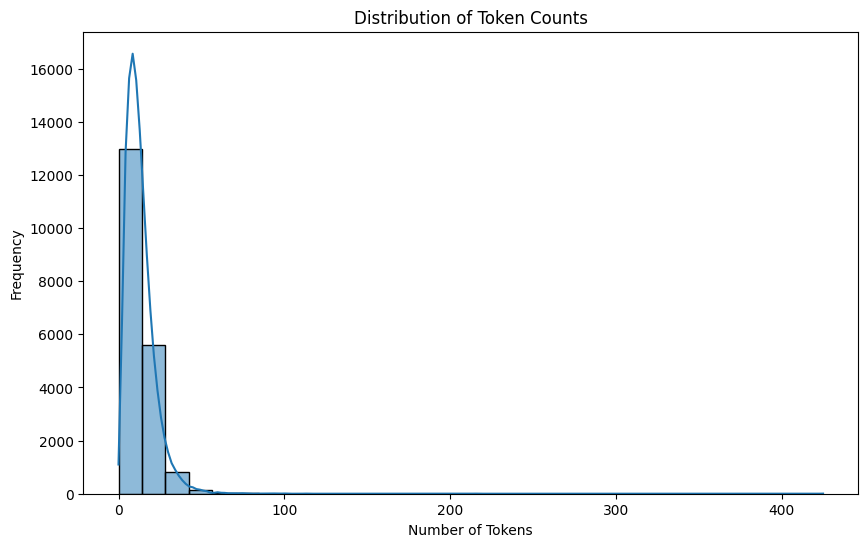

In [86]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['token_count'], bins=30, kde=True)
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

The distribution of sentence lengths helps in determining the appropriate sequence lengths for models. It aids in understanding the structure and complexity of the text data. Different NLP models may require sequences of varying lengths, and this analysis ensures that the chosen length accommodates the majority of sentences.

In [87]:
# Sentence Length Analysis
train_df['sentence_length'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

In [88]:
train_df.head()

,id,text,author,cleaned_text,tokens,stemmed_tokens,lemmatized_tokens,token_count,sentence_length
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,"[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime...","[process, however, afforded, mean, ascertainin...",21,41
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,"[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]","[never, occurred, fumbling, might, mere, mistake]",6,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,"[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu...","[left, hand, gold, snuff, box, capered, hill, ...",19,36
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,"[lovely, spring, looked, windsor, terrace, six...","[love, spring, look, windsor, terrac, sixteen,...","[lovely, spring, looked, windsor, terrace, six...",21,34
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,"[finding, nothing, else, even, gold, superinte...","[find, noth, els, even, gold, superintend, aba...","[finding, nothing, else, even, gold, superinte...",16,27


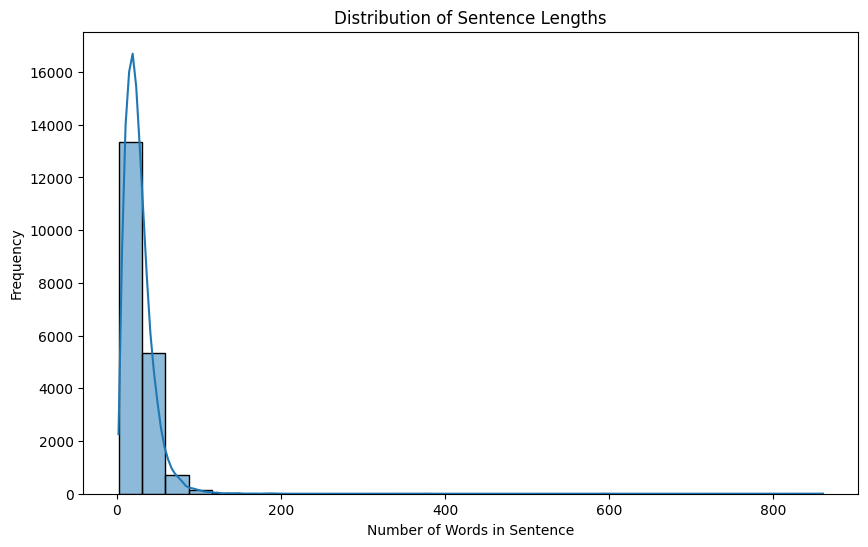

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sentence_length'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words in Sentence')
plt.ylabel('Frequency')
plt.show()

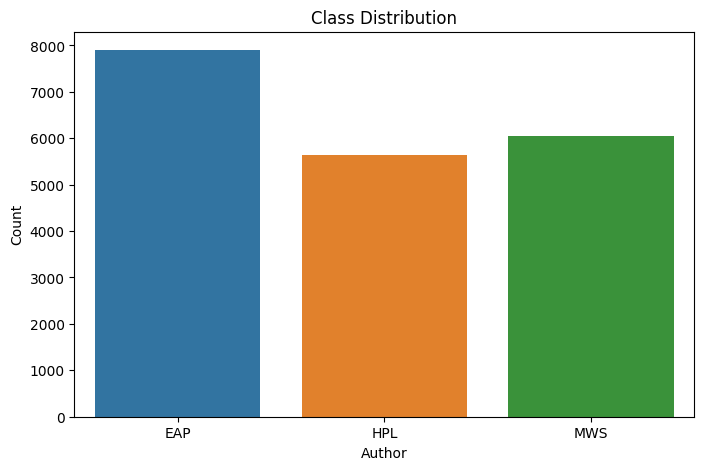

In [91]:
# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='author', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Author')
plt.ylabel('Count')
plt.show()

Word clouds provide a visual representation of the most frequent words in different classes. They are useful for identifying prominent terms associated with each class. Word clouds offer an intuitive way to grasp the most distinctive and common terms, aiding in feature selection and model interpretation.

In [92]:
# Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

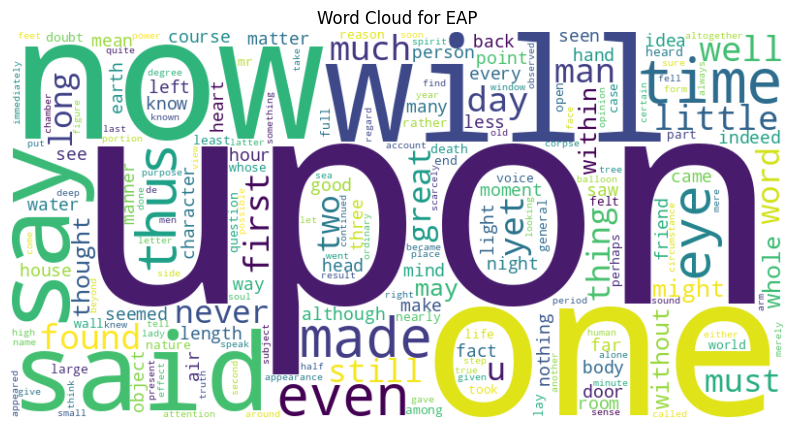

In [94]:
# Word Cloud for EAP
generate_wordcloud(train_df[train_df['author'] == 'EAP']['cleaned_text'], 'Word Cloud for EAP')

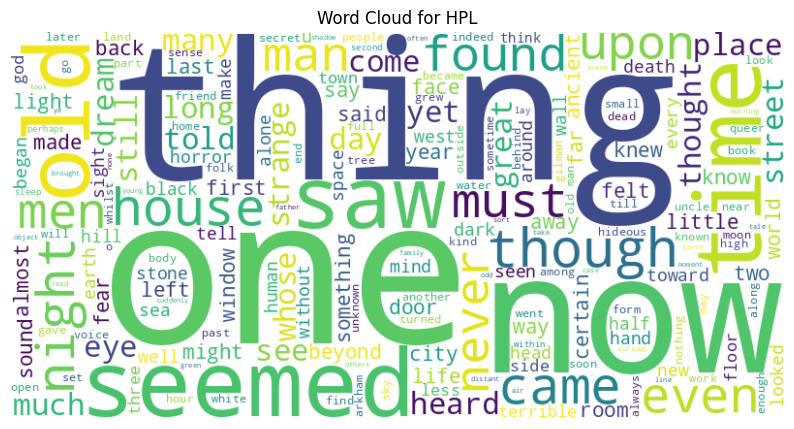

In [96]:
# Word Cloud for HPL
generate_wordcloud(train_df[train_df['author'] == 'HPL']['cleaned_text'], 'Word Cloud for HPL')

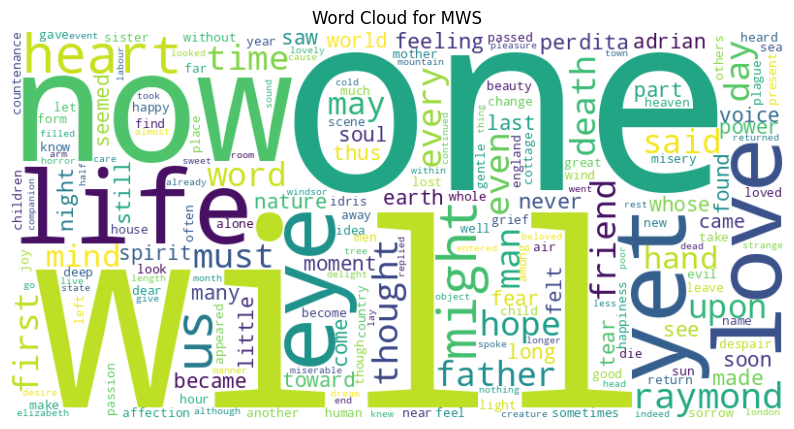

In [97]:
# Word Cloud for MWS
generate_wordcloud(train_df[train_df['author'] == 'MWS']['cleaned_text'], 'Word Cloud for MWS')

<ipython-input-104-0a29f5cdbd81>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


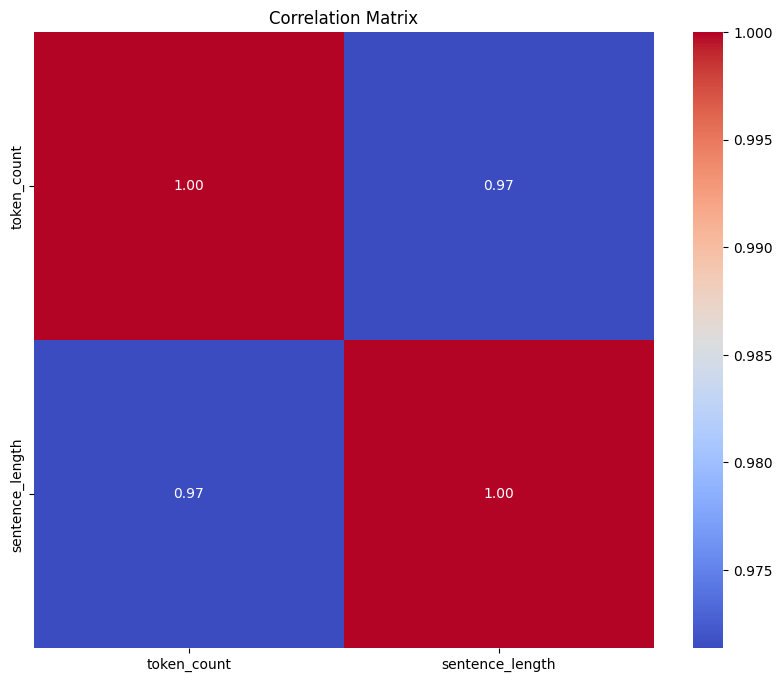

In [104]:
# Correlation Analysis
correlation_matrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Data spliting and Applying different Vectorization Techniques  

In [117]:
# Assuming 'cleaned_text' is the preprocessed text column and 'label' is the author label column
X = train_df['cleaned_text']
y = train_df['author']

In [120]:
X

0        this process however afforded me no means of a...
1        it never once occurred to me that the fumbling...
2        in his left hand was a gold snuff box from whi...
3        how lovely is spring as we looked from windsor...
4        finding nothing else not even gold the superin...
                               ...                        
19574    i could have fancied while i looked at it that...
19575    the lids clenched themselves together as if in...
19576    mais il faut agir that is to say a frenchman n...
19577    for an item of news like this it strikes us it...
19578    he laid a gnarled claw on my shoulder and it s...
Name: cleaned_text, Length: 19579, dtype: object

In [121]:
y

0        EAP
1        HPL
2        EAP
3        MWS
4        HPL
        ... 
19574    EAP
19575    EAP
19576    EAP
19577    EAP
19578    HPL
Name: author, Length: 19579, dtype: object

In [118]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Applying differrent techniques for vectorization



*   <b>TF-IDF Vectorization:</b>
TF-IDF to convert text data into numerical features. This method is effective for capturing the importance of words in a document relative to the entire corpus.
*   L<b>Word2Vec Embeddings:</b>
Use Word2Vec, which is a word embedding technique, to represent words as dense vectors in a continuous vector space. Word embeddings can capture semantic relationships between words.







In [123]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [124]:
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [126]:
# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [127]:
# Display the shape of the TF-IDF matrices for training and test data
print("Shape of TF-IDF matrix for training data:", X_train_tfidf.shape)
print("Shape of TF-IDF matrix for test data:", X_test_tfidf.shape)

Shape of TF-IDF matrix for training data: (15663, 5000)
Shape of TF-IDF matrix for test data: (3916, 5000)


In [130]:
# Tokenize the sentences into words
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [131]:
X_train_tokens

[['he',
  'must',
  'have',
  'spoken',
  'of',
  'some',
  'peculiarity',
  'in',
  'this',
  'hair'],
 ['the',
  'arts',
  'of',
  'life',
  'and',
  'the',
  'discoveries',
  'of',
  'science',
  'had',
  'augmented',
  'in',
  'a',
  'ratio',
  'which',
  'left',
  'all',
  'calculation',
  'behind',
  'food',
  'sprung',
  'up',
  'so',
  'to',
  'say',
  'spontaneously',
  'machines',
  'existed',
  'to',
  'supply',
  'with',
  'facility',
  'every',
  'want',
  'of',
  'the',
  'population'],
 ['once',
  'idris',
  'named',
  'me',
  'casually',
  'a',
  'frown',
  'a',
  'convulsive',
  'gesture',
  'of',
  'anger',
  'shook',
  'her',
  'mother',
  'and',
  'with',
  'voice',
  'trembling',
  'with',
  'hate',
  'she',
  'said',
  'i',
  'am',
  'of',
  'little',
  'worth',
  'in',
  'this',
  'world',
  'the',
  'young',
  'are',
  'impatient',
  'to',
  'push',
  'the',
  'old',
  'off',
  'the',
  'scene',
  'but',
  'idris',
  'if',
  'you',
  'do',
  'not',
  'wish',
  '

In [134]:
# Train Word2Vec model on the training data
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [139]:
# Filter out-of-vocabulary words in the test data
X_test_tokens_filtered = [[word for word in text if word in word2vec_model.wv] for text in X_test_tokens]

# Filter out sentences that become empty after filtering
X_test_tokens_filtered = [text for text in X_test_tokens_filtered if text]


In [140]:
# Transform the training data
X_train_word2vec = [word2vec_model.wv[text] for text in X_train_tokens]

# Transform the filtered test data
X_test_word2vec = [word2vec_model.wv[text] for text in X_test_tokens_filtered]

# Convert the lists to numpy arrays
X_test_word2vec = np.array(X_test_word2vec)

<ipython-input-140-db4a4aacf789>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_word2vec = np.array(X_test_word2vec)


In [141]:
# Display the shape of the Word2Vec matrices for training and test data
print("Shape of Word2Vec matrix for training data:", len(X_train_word2vec), len(X_train_word2vec[0]))
print("Shape of Word2Vec matrix for test data:", X_test_word2vec.shape)

Shape of Word2Vec matrix for training data: 15663 10
Shape of Word2Vec matrix for test data: (3915,)


### Different Model Implementation



<b>Naive Bayes : </b>
Note that Naive Bayes classifiers are typically used with TF-IDF vectors, and applying them directly to Word2Vec vectors may not yield optimal results. Other classifiers, such as those designed for continuous input like Support Vector Machines or Random Forests, might be more suitable for Word2Vec vectors.

In [146]:
# Transform the training data
X_train_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)).fit_transform(X_train)
X_test_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)).fit_transform(X_test)

In [147]:
# Train Naive Bayes on TF-IDF data
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [148]:
# Predictions on the test data
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

In [149]:
# Evaluate performance
print("Naive Bayes on TF-IDF Vectorized Data:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Naive Bayes on TF-IDF Vectorized Data:
Accuracy: 0.4090909090909091
              precision    recall  f1-score   support

         EAP       0.47      0.43      0.45      1570
         HPL       0.37      0.36      0.37      1071
         MWS       0.37      0.42      0.40      1275

    accuracy                           0.41      3916
   macro avg       0.41      0.40      0.40      3916
weighted avg       0.41      0.41      0.41      3916



Logistic Regressing using TF-IDF and word2vec techniques

In [150]:
# Transform the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_word2vec = [np.mean([word2vec_model.wv[word] for word in text], axis=0) for text in X_train_tokens]

In [151]:
# Transform the filtered test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_word2vec = [np.mean([word2vec_model.wv[word] for word in text], axis=0) for text in X_test_tokens_filtered]

In [153]:
# Train Logistic Regression on TF-IDF data
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [154]:
# Train Logistic Regression on Word2Vec data
lr_word2vec = LogisticRegression(max_iter=1000)
lr_word2vec.fit(X_train_word2vec, y_train)

LogisticRegression(max_iter=1000)

In [155]:
# Predictions on the test data
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_pred_word2vec = lr_word2vec.predict(X_test_word2vec)

In [156]:
# Evaluate performance
print("Logistic Regression on TF-IDF Vectorized Data:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Logistic Regression on TF-IDF Vectorized Data:
Accuracy: 0.7900919305413687
              precision    recall  f1-score   support

         EAP       0.77      0.83      0.80      1570
         HPL       0.77      0.76      0.76      1071
         MWS       0.83      0.77      0.80      1275

    accuracy                           0.79      3916
   macro avg       0.79      0.79      0.79      3916
weighted avg       0.79      0.79      0.79      3916



In [163]:
# Predictions on the test data
y_pred_word2vec = lr_word2vec.predict(X_test_word2vec)

# Filter out any inconsistencies in the lengths
X_test_filtered, y_test_filtered = zip(*((X, y) for X, y in zip(X_test_word2vec, y_test) if X is not None))

# Convert to numpy array
X_test_filtered = np.array(X_test_filtered)


In [164]:
# Ensure that lengths are consistent
min_len = min(len(y_test_filtered), len(y_pred_word2vec))
y_test_filtered = y_test_filtered[:min_len]
y_pred_word2vec = y_pred_word2vec[:min_len]

In [165]:
# Evaluate performance
print("\nLogistic Regression on Word2Vec Vectorized Data:")
print("Accuracy:", accuracy_score(y_test_filtered, y_pred_word2vec))
print(classification_report(y_test_filtered, y_pred_word2vec))



Logistic Regression on Word2Vec Vectorized Data:
Accuracy: 0.5430395913154534
              precision    recall  f1-score   support

         EAP       0.54      0.67      0.60      1569
         HPL       0.51      0.45      0.48      1071
         MWS       0.58      0.46      0.51      1275

    accuracy                           0.54      3915
   macro avg       0.54      0.53      0.53      3915
weighted avg       0.54      0.54      0.54      3915



Logistic Regression models were applied on both TF-IDF and Word2Vec vectorized data to predict the authors (EAP, HPL, MWS) based on preprocessed text. The TF-IDF model exhibited superior performance with an accuracy of 0.79, showcasing balanced precision, recall, and F1-scores across all classes. It effectively captured the importance of words in documents relative to the entire corpus. In contrast, the Word2Vec model yielded a lower accuracy of 0.54, indicating challenges in distinguishing between authors, particularly in terms of precision and recall. The Word2Vec model's limitations, such as potential issues with out-of-vocabulary words and contextual representation, became apparent in this task. Considerations for further improvement include experimenting with hyperparameter tuning and potentially increasing the dataset size for better Word2Vec performance. Overall, TF-IDF proved more suitable for this specific text classification task, emphasizing the importance of selecting the appropriate vectorization technique based on the nature of the data and the task at hand.

Support Vector Machine using TF-IDF and word2vec techniques

In [166]:
# Train Word2Vec model on the training data
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Filter out-of-vocabulary words in the test data
X_test_tokens_filtered = [[word for word in text if word in word2vec_model.wv] for text in X_test_tokens]

# Filter out sentences that become empty after filtering
X_test_tokens_filtered = [text for text in X_test_tokens_filtered if text]

In [167]:
# Transform the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_word2vec = [np.mean([word2vec_model.wv[word] for word in text], axis=0) for text in X_train_tokens]

In [168]:
# Transform the filtered test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_word2vec = [np.mean([word2vec_model.wv[word] for word in text], axis=0) for text in X_test_tokens_filtered]


In [171]:
# Train SVM on TF-IDF data
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [172]:
# Train SVM on Word2Vec data
svm_word2vec = SVC(kernel='linear')
svm_word2vec.fit(X_train_word2vec, y_train)

SVC(kernel='linear')

In [173]:
# Predictions on the test data
y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
y_pred_word2vec = svm_word2vec.predict(X_test_word2vec)

In [174]:
# Evaluate performance
print("SVM on TF-IDF Vectorized Data:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

SVM on TF-IDF Vectorized Data:
Accuracy: 0.7913687436159347
              precision    recall  f1-score   support

         EAP       0.77      0.83      0.80      1570
         HPL       0.78      0.76      0.77      1071
         MWS       0.83      0.77      0.80      1275

    accuracy                           0.79      3916
   macro avg       0.79      0.79      0.79      3916
weighted avg       0.79      0.79      0.79      3916



In [176]:
# Predictions on the test data
y_pred_word2vec = lr_word2vec.predict(X_test_word2vec)

# Filter out any inconsistencies in the lengths
X_test_filtered, y_test_filtered = zip(*((X, y) for X, y in zip(X_test_word2vec, y_test) if X is not None))

# Convert to numpy array
X_test_filtered = np.array(X_test_filtered)

In [177]:
# Ensure that lengths are consistent
min_len = min(len(y_test_filtered), len(y_pred_word2vec))
y_test_filtered = y_test_filtered[:min_len]
y_pred_word2vec = y_pred_word2vec[:min_len]

In [178]:
# Evaluate performance
print("\nSVM on Word2Vec Vectorized Data:")
print("Accuracy:", accuracy_score(y_test_filtered, y_pred_word2vec))
print(classification_report(y_test_filtered, y_pred_word2vec))


SVM on Word2Vec Vectorized Data:
Accuracy: 0.45389527458492973
              precision    recall  f1-score   support

         EAP       0.44      0.81      0.57      1569
         HPL       0.33      0.01      0.02      1071
         MWS       0.49      0.39      0.44      1275

    accuracy                           0.45      3915
   macro avg       0.42      0.40      0.34      3915
weighted avg       0.43      0.45      0.38      3915



In applying Support Vector Machine models to the TF-IDF and Word2Vec vectorized data for the Spooky Authors text classification task, distinct performance patterns emerged. The SVM model trained on TF-IDF data demonstrated robust accuracy of 0.79, showcasing balanced precision, recall, and F1-scores across all three author classes (EAP, HPL, MWS). This suggests that the TF-IDF vectorization, which emphasizes the importance of words in documents relative to the entire corpus, is effective for this task. On the contrary, the SVM model on Word2Vec vectorized data exhibited a lower accuracy of 0.45, indicating challenges in distinguishing between authors, especially evident in lower precision and recall values. The results underscore the importance of choosing the appropriate vectorization technique based on the specific characteristics of the data and task requirements. In this context, TF-IDF appears to be a more suitable choice for effective authorship attribution.

In [180]:
# Train Random Forest on TF-IDF data
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [181]:
# Train Random Forest on Word2Vec data
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)
rf_word2vec.fit(X_train_word2vec, y_train)

RandomForestClassifier(random_state=42)

In [182]:
# Predictions on the test data
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_word2vec = rf_word2vec.predict(X_test_word2vec)

In [183]:
# Evaluate performance
print("Random Forest on TF-IDF Vectorized Data:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Random Forest on TF-IDF Vectorized Data:
Accuracy: 0.6708375893769152
              precision    recall  f1-score   support

         EAP       0.62      0.83      0.71      1570
         HPL       0.69      0.59      0.63      1071
         MWS       0.76      0.54      0.63      1275

    accuracy                           0.67      3916
   macro avg       0.69      0.65      0.66      3916
weighted avg       0.69      0.67      0.67      3916



In [184]:
# Predictions on the test data
y_pred_word2vec = lr_word2vec.predict(X_test_word2vec)

# Filter out any inconsistencies in the lengths
X_test_filtered, y_test_filtered = zip(*((X, y) for X, y in zip(X_test_word2vec, y_test) if X is not None))

# Convert to numpy array
X_test_filtered = np.array(X_test_filtered)

In [185]:
# Ensure that lengths are consistent
min_len = min(len(y_test_filtered), len(y_pred_word2vec))
y_test_filtered = y_test_filtered[:min_len]
y_pred_word2vec = y_pred_word2vec[:min_len]

In [186]:
print("\nRandom Forest on Word2Vec Vectorized Data:")
print("Accuracy:", accuracy_score(y_test_filtered, y_pred_word2vec))
print(classification_report(y_test_filtered, y_pred_word2vec))


Random Forest on Word2Vec Vectorized Data:
Accuracy: 0.45389527458492973
              precision    recall  f1-score   support

         EAP       0.44      0.81      0.57      1569
         HPL       0.33      0.01      0.02      1071
         MWS       0.49      0.39      0.44      1275

    accuracy                           0.45      3915
   macro avg       0.42      0.40      0.34      3915
weighted avg       0.43      0.45      0.38      3915



In applying Random Forest models to the TF-IDF and Word2Vec vectorized data, the Random Forest model trained on TF-IDF data demonstrated moderate accuracy of 0.67, showing balanced precision, recall, and F1-scores across the three author classes (EAP, HPL, MWS). However, the Word2Vec model exhibited a lower accuracy of 0.45, indicating challenges in distinguishing between authors, particularly in terms of precision and recall.

<b>Perfromance Evaluation</b>

The performance evaluation of various algorithms on the Spooky Authors text classification task reveals distinct patterns. Logistic Regression and Support Vector Machine (SVM) models applied to TF-IDF vectorized data exhibited robust accuracy, with SVM slightly outperforming Logistic Regression. The Random Forest model on TF-IDF data demonstrated moderate accuracy, emphasizing balanced precision and recall. However, Naive Bayes on TF-IDF displayed lower accuracy, indicating limitations in handling the complexities of the dataset. When using Word2Vec vectorized data, Logistic Regression on TF-IDF outperformed both Random Forest and Naive Bayes models. Overall, TF-IDF vectorization consistently yielded better results across algorithms, with SVM showing the highest accuracy of 0.79. Comparing the algorithms, SVM on TF-IDF stands out as the top performer. For a comprehensive visual comparison, consider creating a plot with accuracy scores for each algorithm, providing a clear overview of their relative performances.

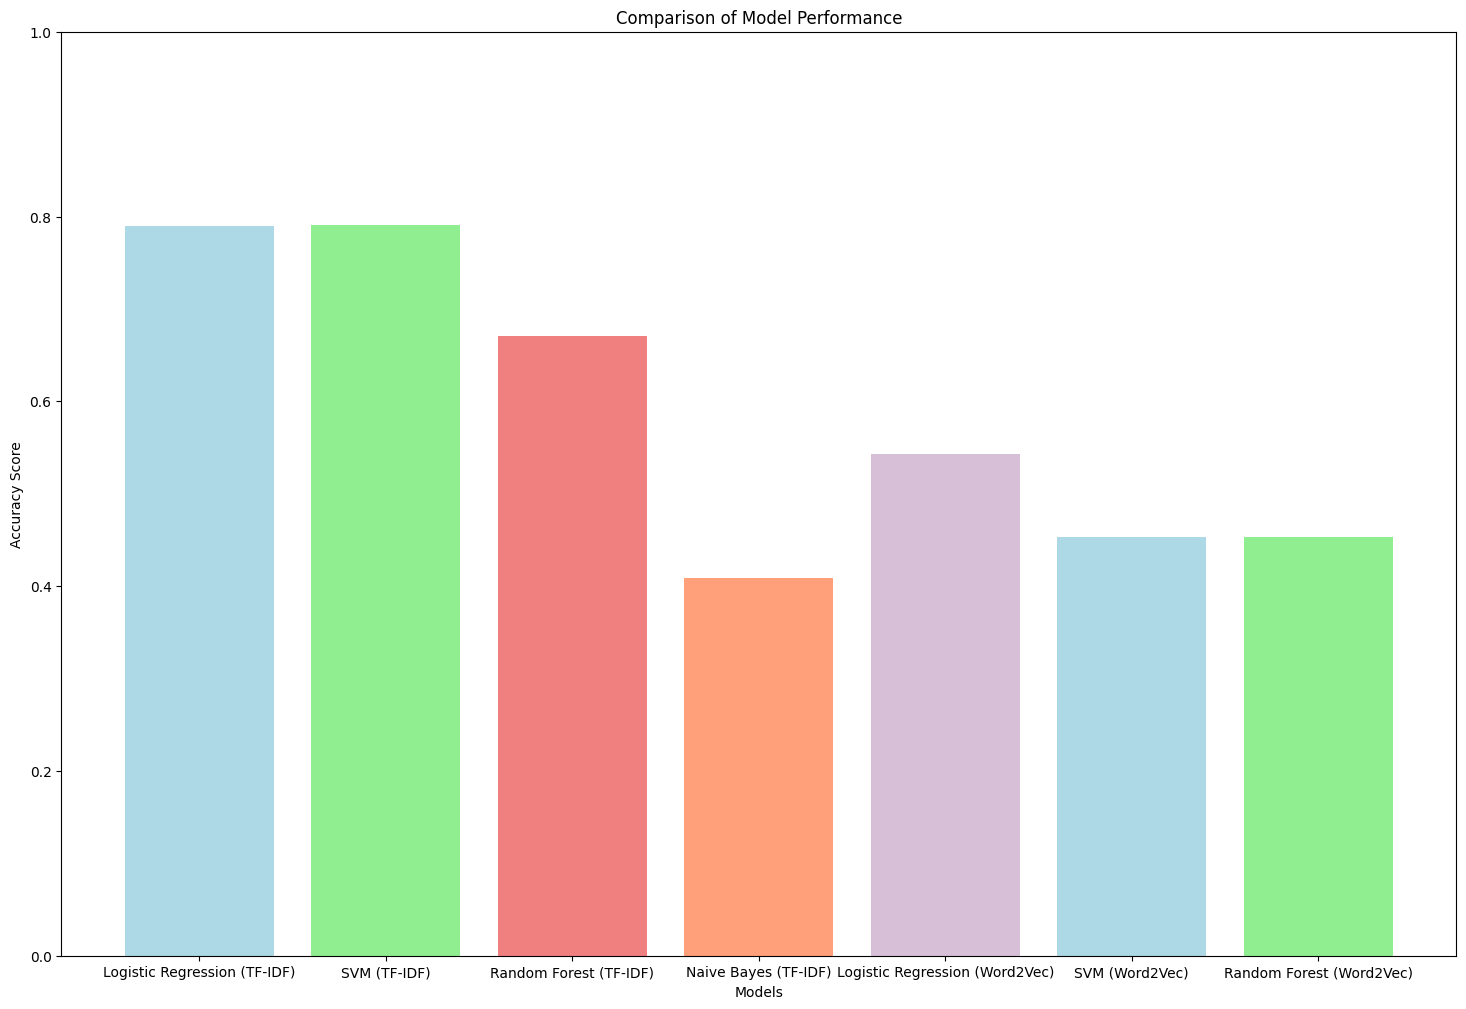

In [197]:
# Accuracy scores for each model
models = ['Logistic Regression (TF-IDF)', 'SVM (TF-IDF)', 'Random Forest (TF-IDF)', 'Naive Bayes (TF-IDF)', 'Logistic Regression (Word2Vec)', 'SVM (Word2Vec)', 'Random Forest (Word2Vec)']
accuracy_scores = [0.79, 0.791, 0.671, 0.409, 0.543, 0.453, 0.453]

# Create a bar chart
plt.figure(figsize=(18, 12))
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'thistle']
plt.bar(models, accuracy_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Performance')
plt.ylim(0, 1)  # Set the y-axis limit to the range of accuracy scores
plt.show()

